# flight delay predictor for TunisAir

In [504]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb

## split dataset into train & test

In [505]:
df = pd.read_csv('./data/Data.csv')

### dropping outliers from main dataset

In [506]:
Q1 = df['target'].quantile(0.25)
Q3 = df['target'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 2.5 * IQR
df['target'] = np.clip(df['target'], 0, upper_bound)

In [507]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=17
)

In [508]:
X_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
27598,train_id_27598,2016-09-10,TU 0717,ORY,TUN,2016-09-10 10:15:00,2016-09-10 12.40.00,ATA,TU 32AIMH
98934,train_id_98934,2018-11-30,TU 0634,DJE,ORY,2018-11-30 06:30:00,2018-11-30 09.15.00,ATA,TU 736IOQ
18670,train_id_18670,2016-08-04,UG 1310,TUN,CDG,2016-08-04 18:15:00,2016-08-04 20.30.00,ATA,TU 31BIMO
49984,train_id_49984,2017-10-17,TU 0706,CMN,TUN,2017-10-17 19:35:00,2017-10-17 21.55.00,ATA,TU 320IMV
30122,train_id_30122,2016-06-27,UG 0003,DJE,TUN,2016-06-27 07:45:00,2016-06-27 08.45.00,SCH,UG AT7LBE


In [509]:
df['target'].mean()

np.float64(34.0405395379893)

**the mean delay is about 48.73 minutes**

---
## data cleaning

### convert date formats

In [510]:
X_train['STD'] =  pd.to_datetime(X_train['STD'], format='%Y-%m-%d %H:%M:%S')
X_train['STA'] =  pd.to_datetime(X_train['STA'], format='%Y-%m-%d %H.%M.%S')
X_train['DATOP'] =  pd.to_datetime(X_train['DATOP'], format='%Y-%m-%d')

X_test['STD'] =  pd.to_datetime(X_test['STD'], format='%Y-%m-%d %H:%M:%S')
X_test['STA'] =  pd.to_datetime(X_test['STA'], format='%Y-%m-%d %H.%M.%S')
X_test['DATOP'] =  pd.to_datetime(X_test['DATOP'], format='%Y-%m-%d')

In [511]:
df['STATUS'].unique()

array(['ATA', 'DEP', 'RTR', 'SCH', 'DEL'], dtype=object)

*status column is data leakage so it needs to be dropped*

In [512]:
X_train = X_train.drop('STATUS', axis=1)
X_test = X_test.drop('STATUS', axis=1)

In [513]:
df.isnull().sum(axis=0).reset_index()

,index,0
0,ID,0
1,DATOP,0
2,FLTID,0
3,DEPSTN,0
4,ARRSTN,0
5,STD,0
6,STA,0
7,STATUS,0
8,AC,0
9,target,0


**no missing values in the dataset**

---
## relationship between delay & route (departure -> arrival) 

In [514]:
dep_delay = df.groupby("DEPSTN")["target"].mean().reset_index()
dep_delay = dep_delay.rename(columns={"target": "mean_delay"})

arr_delay = df.groupby("ARRSTN")["target"].mean().reset_index()
arr_delay = arr_delay.rename(columns={"target": "mean_delay"})

print(dep_delay["mean_delay"].describe())
print(arr_delay["mean_delay"].describe())


count    132.000000
mean      36.618592
std       33.523058
min        0.000000
25%       14.086538
50%       33.620934
75%       51.102888
max      150.500000
Name: mean_delay, dtype: float64
count    128.000000
mean      34.160719
std       29.703888
min        0.000000
25%       15.000000
50%       29.604114
75%       45.649068
max      150.500000
Name: mean_delay, dtype: float64


In [515]:
model = ols("target ~ C(DEPSTN)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

model2 = ols("target ~ C(ARRSTN)", data=df).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)
print(anova_table2)

                 sum_sq        df          F  PR(>F)
C(DEPSTN)  1.377633e+07     131.0  49.291435     0.0
Residual   2.297792e+08  107701.0        NaN     NaN
                 sum_sq        df          F  PR(>F)
C(ARRSTN)  7.601496e+06     127.0  27.321458     0.0
Residual   2.359540e+08  107705.0        NaN     NaN


p-values are both low *(below 0.5)*, therefore the arrival and departure points have an effect on delay

---
## relationship between aircraft usage & delay

In [516]:
ac_usage = df.groupby("AC").size().reset_index(name="flight_count")
ac_delay = df.groupby("AC")["target"].mean().reset_index(name="mean_delay")
ac_stats = ac_usage.merge(ac_delay, on="AC")
print(ac_stats.head())

          AC  flight_count  mean_delay
0  5K 343TQY            54   51.925926
1  5K 345TFX           214   63.345794
2  5M 343FOX            63   37.206349
3  5M 343JAI           129   51.476744
4  5M 343SUN            68   79.661765


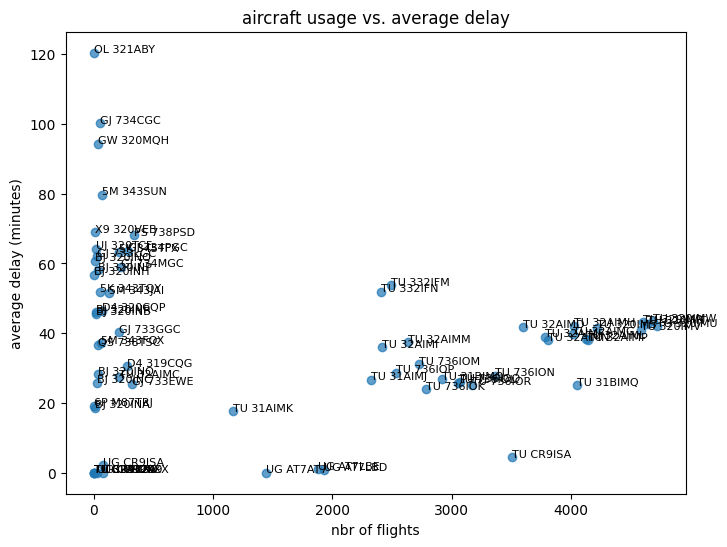

In [517]:
plt.figure(figsize=(8,6))
plt.scatter(ac_stats["flight_count"], ac_stats["mean_delay"], alpha=0.7)

plt.xlabel("nbr of flights")
plt.ylabel("average delay (minutes)")
plt.title("aircraft usage vs. average delay")

# Optional: label some points
for i, row in ac_stats.iterrows():
    plt.text(row["flight_count"], row["mean_delay"], row["AC"], fontsize=8)

plt.show()

+ high usage aircrafts have stable delays *(normal delays)*
+ low usage aircrafts have extreme averages 

In [518]:
ac_stats["flight_count"].corr(ac_stats["mean_delay"])

np.float64(-0.13038566302591395)

-> no correlation between aircraft & delay

---
## relationship between delay & the month

    month     target
0       1  28.150289
1       2  19.485958
2       3  35.482822
3       4  35.721443
4       5  35.338859
5       6  30.831626
6       7  40.312244
7       8  43.629051
8       9  41.458541
9      10  26.097771
10     11  24.680106
11     12  35.012809


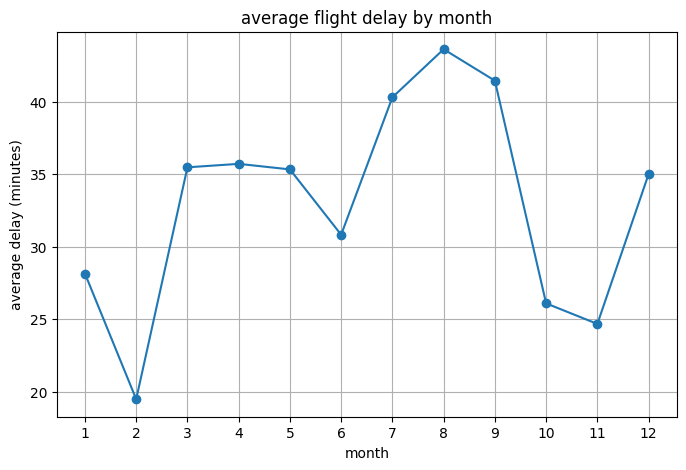

In [519]:
df["month"] = pd.to_datetime(df["DATOP"]).dt.month
month_delay = df.groupby("month")["target"].mean().reset_index()
print(month_delay)

plt.figure(figsize=(8,5))
plt.plot(month_delay["month"], month_delay["target"], marker="o")
plt.xticks(range(1,13))
plt.xlabel("month")
plt.ylabel("average delay (minutes)")
plt.title("average flight delay by month")
plt.grid(True)
plt.show()

+ more delays on summer months (july, august, september)
+ early months (jan, feb) and late fall (oct, nov) show lower delays.

---
## feature engineering

In [520]:
X_train['trajectory'] = X_train['DEPSTN'] + '-' + X_train['ARRSTN']
X_test['trajectory'] = X_test['DEPSTN'] + '-' + X_test['ARRSTN']
X_train['trajectory'].nunique()


722

In [521]:
X_train['month'] = pd.DatetimeIndex(X_train['DATOP']).month.values
X_train['day'] = pd.DatetimeIndex(X_train['DATOP']).day.values
X_train['day_of_week'] = pd.DatetimeIndex(X_train['DATOP']).dayofweek.values
X_train['year'] = pd.DatetimeIndex(X_train['DATOP']).year.values
X_train['week_of_year'] = pd.DatetimeIndex(X_train['DATOP']).isocalendar().week.astype(int).values
X_train['week_of_month'] = ((pd.DatetimeIndex(X_train['DATOP']).day - 1) // 7 + 1).values

In [522]:
X_test['month'] = pd.DatetimeIndex(X_test['DATOP']).month.values
X_test['day'] = pd.DatetimeIndex(X_test['DATOP']).day.values
X_test['day_of_week'] = pd.DatetimeIndex(X_test['DATOP']).dayofweek.values
X_test['year'] = pd.DatetimeIndex(X_test['DATOP']).year.values
X_test['week_of_year'] = pd.DatetimeIndex(X_test['DATOP']).isocalendar().week.astype(int).values
X_test['week_of_month'] = ((pd.DatetimeIndex(X_test['DATOP']).day - 1) // 7 + 1).values

**adding a season for each flight**

In [523]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0 #winter
    elif month in [3, 4, 5]:
        return 1 #spring
    elif month in [6, 7, 8]:
        return 2 #summer
    else:  # 9, 10, 11
        return 3 #fall
    
X_train['season'] = X_train['month'].apply(get_season)
X_test['season'] = X_test['month'].apply(get_season)

In [524]:
X_train['dep_hour'] = pd.DatetimeIndex(X_train['STD']).hour 
X_test['dep_hour'] = pd.DatetimeIndex(X_test['STD']).hour

X_train['arr_hour'] = pd.DatetimeIndex(X_train['STA']).hour 
X_test['arr_hour'] = pd.DatetimeIndex(X_test['STA']).hour

In [525]:
X_train['dep_minute'] = pd.DatetimeIndex(X_train['STD']).minute 
X_test['dep_minute'] = pd.DatetimeIndex(X_test['STD']).minute

X_train['arr_minute'] = pd.DatetimeIndex(X_train['STA']).minute 
X_test['arr_minute'] = pd.DatetimeIndex(X_test['STA']).minute

In [526]:
X_train['flight_duration_sec'] = (X_train['STA'] - X_train['STD']).values.astype(np.int64)
X_test['flight_duration_sec'] = (X_test['STA'] - X_test['STD']).values.astype(np.int64)

In [527]:
X_train['flight_duration_hours'] = X_train['arr_hour'] - X_train['dep_hour'] 
X_test['flight_duration_hours'] = X_test['arr_hour'] - X_test['dep_hour']

In [528]:
X_train['flight_duration_minutes'] = (X_train['flight_duration_sec'] / 60).astype(np.int64)
X_test['flight_duration_minutes'] = (X_test['flight_duration_sec'] / 60).astype(np.int64)

**arrival hour type (AM/PM)**

In [529]:
data = [X_train, X_test]
for dataset in data:
    dataset.loc[ (dataset['dep_hour'] < 12) , 'dep_hour_AM_PM'] = 0
    dataset.loc[(dataset['dep_hour'] >= 12) , 'dep_hour_AM_PM'] = 1
    dataset['dep_hour_AM_PM'] = dataset['dep_hour_AM_PM'].astype(int)

    dataset.loc[ (dataset['arr_hour'] < 12) , 'arr_hour_AM_PM'] = 0
    dataset.loc[(dataset['arr_hour'] >= 12) , 'arr_hour_AM_PM'] = 1
    dataset['arr_hour_AM_PM'] = dataset['arr_hour_AM_PM'].astype(int)

In [530]:
X_train['S_dep_hour'] = np.sin(2*np.pi*X_train['dep_hour']/24)
X_train['C_dep_hour'] = np.cos(2*np.pi*X_train['dep_hour']/24)
X_test['S_dep_hour'] = np.sin(2*np.pi*X_test['dep_hour']/24)
X_test['C_dep_hour'] = np.cos(2*np.pi*X_test['dep_hour']/24)

X_train['S_arr_hour'] = np.sin(2*np.pi*X_train['arr_hour']/24)
X_train['C_arr_hour'] = np.cos(2*np.pi*X_train['arr_hour']/24)
X_test['S_arr_hour'] = np.sin(2*np.pi*X_test['arr_hour']/24)
X_test['C_arr_hour'] = np.cos(2*np.pi*X_test['arr_hour']/24)

In [531]:
data = [X_train, X_test]

for dataset in data:
    for i in range(dataset.shape[0]):
        dataset.loc[dataset.index[i], 'day_of_year'] = int(dataset.iloc[i]['DATOP'].strftime('%j'))


**frequency of aircraft usage**

In [532]:
aircraft_counts = df['AC'].value_counts()
def categorize_usage(ac):
    count = aircraft_counts.get(ac, 0)  # get number of flights for this AC
    if count < 100:
        return 'low'
    elif 100 <= count <= 200:
        return 'medium'
    else:
        return 'high'

X_train['AC_usage'] = X_train['AC'].apply(categorize_usage)
X_test['AC_usage'] = X_test['AC'].apply(categorize_usage)

X_train = pd.get_dummies(X_train, columns=['AC_usage'])
X_test = pd.get_dummies(X_test, columns=['AC_usage'])

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

**encoding categorical variables**

In [533]:
datetime_cols = ['DATOP', 'STD', 'STA']
for col in datetime_cols:
    X_train[col + '_year'] = X_train[col].dt.year
    X_train[col + '_month'] = X_train[col].dt.month
    X_train[col + '_day'] = X_train[col].dt.day
    X_train[col + '_hour'] = X_train[col].dt.hour
    X_train.drop(col, axis=1, inplace=True)
    
    X_test[col + '_year'] = X_test[col].dt.year
    X_test[col + '_month'] = X_test[col].dt.month
    X_test[col + '_day'] = X_test[col].dt.day
    X_test[col + '_hour'] = X_test[col].dt.hour
    X_test.drop(col, axis=1, inplace=True)

In [534]:
categorical_cols = ['FLTID', 'AC', 'trajectory', 'DEPSTN', 'ARRSTN', 'season']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols].astype(str))
X_test[categorical_cols] = encoder.fit_transform(X_test[categorical_cols].astype(str))

In [535]:
X_train = X_train.drop('ID', axis=1)
X_test = X_test.drop('ID', axis=1)

In [536]:
X_train.head()

,FLTID,DEPSTN,ARRSTN,AC,trajectory,month,day,day_of_week,year,week_of_year,...,DATOP_day,DATOP_hour,STD_year,STD_month,STD_day,STD_hour,STA_year,STA_month,STA_day,STA_hour
27598,231.0,94.0,116.0,41.0,496.0,9,10,5,2016,36,...,10,0,2016,9,10,10,2016,9,10,12
98934,201.0,36.0,91.0,54.0,162.0,11,30,4,2018,48,...,30,0,2018,11,30,6,2018,11,30,9
18670,1761.0,120.0,28.0,28.0,617.0,8,4,3,2016,31,...,4,0,2016,8,4,18,2016,8,4,20
49984,222.0,30.0,116.0,34.0,115.0,10,17,1,2017,42,...,17,0,2017,10,17,19,2017,10,17,21
30122,1689.0,36.0,116.0,61.0,172.0,6,27,0,2016,26,...,27,0,2016,6,27,7,2016,6,27,8


In [537]:
X_test.head()

,FLTID,DEPSTN,ARRSTN,AC,trajectory,month,day,day_of_week,year,week_of_year,...,DATOP_day,DATOP_hour,STD_year,STD_month,STD_day,STD_hour,STA_year,STA_month,STA_day,STA_hour
69632,801.0,58.0,88.0,53.0,238.0,12,11,0,2017,50,...,11,0,2017,12,11,12,2017,12,11,13
88753,144.0,27.0,87.0,37.0,103.0,5,8,1,2018,19,...,8,0,2018,5,8,4,2018,5,8,5
3041,188.0,84.0,36.0,39.0,363.0,6,19,6,2016,24,...,19,0,2016,6,19,6,2016,6,19,9
84105,577.0,14.0,58.0,36.0,30.0,8,21,1,2018,34,...,21,0,2018,8,21,20,2018,8,21,23
1829,176.0,67.0,88.0,28.0,280.0,8,21,6,2016,33,...,21,0,2016,8,21,12,2016,8,21,15


## loading model & training

### XGBoost

In [538]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,  
    max_depth=4,         
    min_child_weight=10, 
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,         
    reg_lambda=1,       
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Test RMSE: {rmse}")

Test RMSE: 45.09679783425496


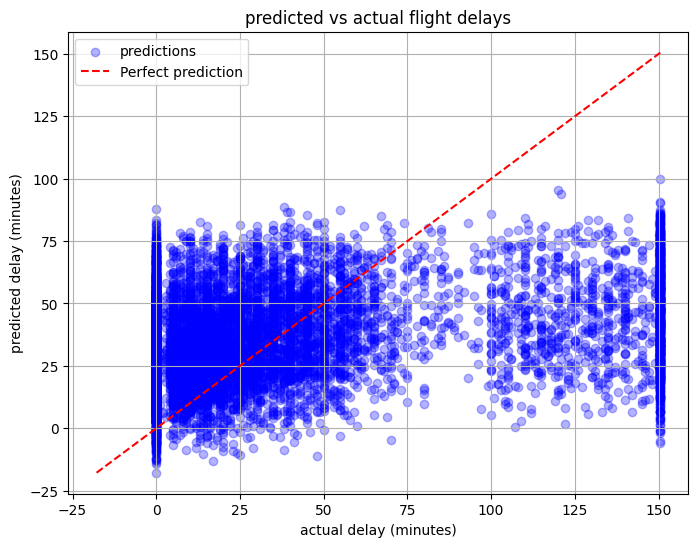

In [539]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha=0.3, color="blue", label="predictions")

lims = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
plt.plot(lims, lims, 'r--', label="Perfect prediction")

plt.xlabel("actual delay (minutes)")
plt.ylabel("predicted delay (minutes)")
plt.title("predicted vs actual flight delays")
plt.legend()
plt.grid(True)
plt.show()

### residual analysis

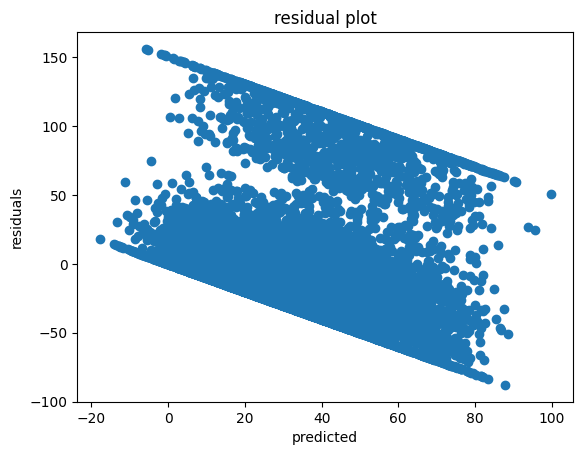

In [540]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('predicted')
plt.ylabel('residuals')
plt.title('residual plot')
plt.show()

In [541]:
feature_importance = model.feature_importances_
important_features = sorted(zip(X_train.columns, feature_importance), 
                           key=lambda x: x[1], reverse=True)
print("Top 10 features:", important_features[:10])

Top 10 features: [('dep_hour_AM_PM', np.float32(0.17376511)), ('S_dep_hour', np.float32(0.092445195)), ('STD_year', np.float32(0.07119077)), ('FLTID', np.float32(0.058719903)), ('STA_hour', np.float32(0.056251336)), ('DATOP_year', np.float32(0.055257935)), ('year', np.float32(0.038322613)), ('dep_hour', np.float32(0.032272946)), ('STA_month', np.float32(0.028024092)), ('arr_hour', np.float32(0.027040947))]
